
# NOTEBOOK 2: MODEL TRAINING AND EVALUATION
# Irish Landmark Recognition Project

# Introduction and Setup
"""
# Irish Landmark Recognition - Model Training & Evaluation

## Objectives
This notebook implements and trains a deep learning model for Irish landmark classification using:
- Transfer Learning with pre-trained CNN models
- PyTorch framework
- Data augmentation techniques
- Comprehensive evaluation metrics

## Model Architecture
- Base model: ResNet-18 (pre-trained on ImageNet)
- Transfer learning approach
- Fine-tuning of final layers
- 6-class classification output
"""

In [1]:
# CELL 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import json
import time
import copy
from pathlib import Path
from tqdm import tqdm
import warnings
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("CPU training - consider using Google Colab for GPU acceleration")


🔧 Using device: cpu
CPU training - consider using Google Colab for GPU acceleration


In [5]:
# CELL 3: Load Dataset Metadata and Configuration
data_dir = Path("data")
metadata_path = data_dir / "comprehensive_dataset_metadata.json"

try:
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Extract metadata with fallbacks
        landmarks = metadata.get('landmarks', {})
        total_images = metadata.get('statistics', {}).get('total_images', 0)
        
        print(" Dataset Statistics:")
        print(f"   • Total images: {total_images}")
        print(f"   • Number of landmarks: {len(landmarks)}")
        
        if not landmarks:
            raise KeyError("No landmark data found in metadata")
            
    else:
        print(" Metadata file not found. Using default configuration.")
        # Define basic config as fallback
        landmarks = {
            'cliffs_of_moher': {'name': 'Cliffs of Moher'},
            'giants_causeway': {'name': "Giant's Causeway"}, 
            'ring_of_kerry': {'name': 'Ring of Kerry'},
            'dublin_castle': {'name': 'Dublin Castle'},
            'killarney_national_park': {'name': 'Killarney National Park'},
            'rock_of_cashel': {'name': 'Rock of Cashel'}
        }

    # Create class mapping
    class_names = [info['name'] for info in landmarks.values()]
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    idx_to_class = {idx: name for name, idx in class_to_idx.items()}

    print("\n Class Mapping:")
    for idx, name in idx_to_class.items():
        print(f"   • {idx}: {name}")
        
    # Save mappings for later use
    class_info = {
        'class_names': class_names,
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'num_classes': len(class_names)
    }
    
except Exception as e:
    print(f"Error loading metadata: {str(e)}")
    print("Please ensure Notebook 1 was run successfully and metadata was generated.")
    raise

 Dataset Statistics:
   • Total images: 853
   • Number of landmarks: 6

 Class Mapping:
   • 0: Cliffs of Moher
   • 1: Giant's Causeway
   • 2: Ring of Kerry
   • 3: Dublin Castle
   • 4: Killarney National Park
   • 5: Rock of Cashel


In [6]:
# CELL 4: Data Transforms and Augmentation
# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize to slightly larger
    transforms.RandomResizedCrop(224),                # Random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),          # Random horizontal flip
    transforms.RandomRotation(degrees=15),           # Random rotation ±15 degrees
    transforms.ColorJitter(                          # Color augmentation
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),  # Perspective change
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(                            # ImageNet normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                   # Resize to exact size
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(                            # ImageNet normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Data transforms defined")


Data transforms defined


In [7]:
# CELL 5: Custom Dataset Class
class IrishLandmarkDataset(Dataset):
    """Custom dataset for Irish landmarks"""
    
    def __init__(self, data_dir, transform=None, split='train'):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.split = split
        
        # Load images and labels
        self.images = []
        self.labels = []
        self.class_names = list(landmarks.keys())
        
        self._load_data()
    
    def _load_data(self):
        """Load image paths and labels"""
        split_dir = self.data_dir / "processed" / self.split
        
        if not split_dir.exists():
            print(f" Directory not found: {split_dir}")
            return
        
        for class_idx, class_key in enumerate(self.class_names):
            class_dir = split_dir / class_key
            
            if class_dir.exists():
                for img_path in class_dir.glob("*.jpg"):
                    self.images.append(str(img_path))
                    self.labels.append(class_idx)
        
        print(f" Loaded {len(self.images)} images for {self.split} split")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        try:
            # Load and process image
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a random other image if this one fails
            return self.__getitem__((idx + 1) % len(self.images))

In [14]:
# CELL 6: Create Data Loaders
def create_data_loaders(data_dir, batch_size=32):
    """Create training and validation data loaders with validation checks"""
    
    # Convert to Path object and check processed directory
    data_dir = Path(data_dir)
    processed_dir = data_dir / "data" / "processed"  # Update path to include "data" directory
    
    # Check if directories exist
    if not processed_dir.exists():
        raise FileNotFoundError(f"Directory not found: {processed_dir}")
        
    # Check train/val directories
    train_dir = processed_dir / "train"
    val_dir = processed_dir / "val"
    
    if not train_dir.exists() or not val_dir.exists():
        raise FileNotFoundError("Train or validation directory missing")
    
    # Create datasets
    train_dataset = IrishLandmarkDataset(
        data_dir=data_dir / "data",  # Update path
        transform=train_transforms,
        split='train'
    )
    
    val_dataset = IrishLandmarkDataset(
        data_dir=data_dir / "data",  # Update path
        transform=val_transforms,
        split='val'
    )
    
    # Validate dataset sizes
    if len(train_dataset) == 0:
        raise ValueError("No training images found")
    if len(val_dataset) == 0:
        raise ValueError("No validation images found")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0  # Set to 0 for simpler debugging
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0  # Set to 0 for simpler debugging
    )
    
    print("\nDataset Information:")
    print(f"Training images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")
    
    return train_loader, val_loader, train_dataset, val_dataset

# Create data loaders with proper error handling
try:
    # Verify directory structure first
    print("Checking directory structure...")
    data_path = Path(".") / "data" / "processed"
    
    if not data_path.exists():
        raise FileNotFoundError(
            "\nData directory not found. Expected structure:\n"
            "./data/processed/\n"
            "  ├── train/\n"
            "  │   └── [landmark_folders]/\n"
            "  └── val/\n"
            "      └── [landmark_folders]/"
        )
    
    # Create data loaders
    batch_size = 32
    train_loader, val_loader, train_dataset, val_dataset = create_data_loaders(
        data_dir=".", 
        batch_size=batch_size
    )
    
except Exception as e:
    print(f"\nError: {e}")
    print("\nTroubleshooting steps:")
    print("1. Make sure Notebook 1 was run successfully")
    print("2. Check directory structure:")
    print("   dir .\\data\\processed\\train")
    print("   dir .\\data\\processed\\val")
    print("3. Verify image files exist in landmark folders")
    raise

Checking directory structure...
 Loaded 708 images for train split
 Loaded 200 images for val split

Dataset Information:
Training images: 708
Validation images: 200


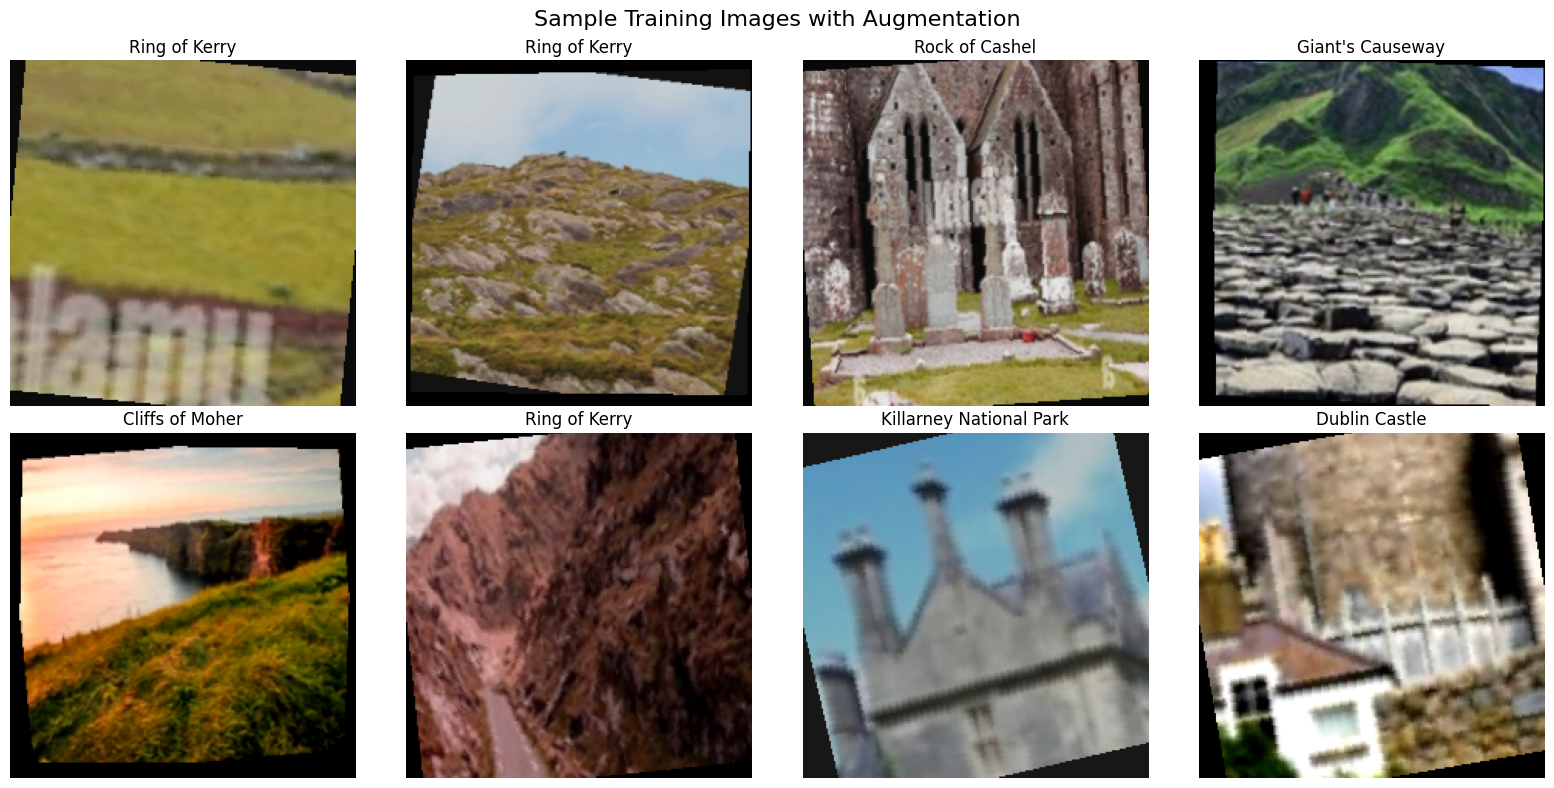

In [21]:
# CELL 7: Visualize Sample Batch
def visualize_batch(data_loader, class_names, num_images=8):
    """Visualize a sample batch of images"""
    
    # Get a batch
    images, labels = next(iter(data_loader))
    
    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    # Select subset of images
    images = images[:num_images]
    labels = labels[:num_images]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx in range(min(num_images, len(images))):
        # Denormalize
        img = images[idx]
        img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[idx].imshow(img_np)
        axes[idx].set_title(f"{class_names[labels[idx]]}")
        axes[idx].axis('off')
    
    plt.suptitle('Sample Training Images with Augmentation', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize sample batch
if len(train_loader) > 0:
    visualize_batch(train_loader, class_names)

In [22]:
# CELL 8: Model Definition
class IrishLandmarkClassifier(nn.Module):
    """Irish Landmark Classifier using transfer learning"""
    
    def __init__(self, num_classes=6, model_name='resnet18', pretrained=True):
        super(IrishLandmarkClassifier, self).__init__()
        
        self.model_name = model_name
        self.num_classes = num_classes
        
        if model_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=pretrained)
            # Freeze early layers for transfer learning
            for param in list(self.backbone.parameters())[:-2]:
                param.requires_grad = False
            
            # Replace final layer
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
            
        elif model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=pretrained)
            for param in list(self.backbone.parameters())[:-4]:
                param.requires_grad = False
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
            
        elif model_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            for param in list(self.backbone.parameters())[:-2]:
                param.requires_grad = False
            self.backbone.classifier[1] = nn.Linear(
                self.backbone.classifier[1].in_features, 
                num_classes
            )
    
    def forward(self, x):
        return self.backbone(x)
    
    def get_trainable_params(self):
        """Get number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [23]:
# CELL 9: Initialize Model and Training Components
# Model configuration
model_name = 'resnet18'  # Options: 'resnet18', 'resnet50', 'efficientnet_b0'
num_classes = len(class_names)

# Initialize model
model = IrishLandmarkClassifier(
    num_classes=num_classes,
    model_name=model_name,
    pretrained=True
).to(device)

print(f" Model: {model_name}")
print(f" Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {model.get_trainable_params():,}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Model and training components initialized")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\aryam/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:06<00:00, 7.19MB/s]

 Model: resnet18
 Total parameters: 11,179,590
Trainable parameters: 3,078
Model and training components initialized


In [24]:
# CELL 10: Training Functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
        # Update progress bar
        current_acc = running_corrects.double() / total_samples
        progress_bar.set_postfix({
            'Loss': f'{running_loss/total_samples:.4f}',
            'Acc': f'{current_acc:.4f}'
        })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')
        
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            # Update progress bar
            current_acc = running_corrects.double() / total_samples
            progress_bar.set_postfix({
                'Loss': f'{running_loss/total_samples:.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

In [25]:
# CELL 11: Main Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=15, patience=5):
    """Complete training loop with early stopping"""
    
    print(f" Starting training for {num_epochs} epochs...")
    
    # Initialize tracking
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f'\n Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Check for best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            print(f' New best validation accuracy: {best_val_acc:.4f}')
        else:
            epochs_without_improvement += 1
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'\n Early stopping after {epoch+1} epochs')
            print(f'No improvement for {patience} consecutive epochs')
            break
    
    training_time = time.time() - start_time
    print(f'\n Training completed in {training_time//60:.0f}m {training_time%60:.0f}s')
    print(f' Best validation accuracy: {best_val_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'training_time': training_time
    }

In [26]:
# CELL 12: Start Training
# Check if we have data to train
if len(train_loader) > 0 and len(val_loader) > 0:
    print(" Ready to start training!")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Start training
    training_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=15,
        patience=5
    )
    
    # Save model
    model_save_path = Path("models") / "irish_landmarks_resnet18.pth"
    model_save_path.parent.mkdir(exist_ok=True)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_name': model_name,
        'num_classes': num_classes,
        'class_names': class_names,
        'training_history': training_history,
        'best_val_acc': training_history['best_val_acc']
    }, model_save_path)
    
    print(f" Model saved to: {model_save_path}")
    
else:
    print(" No training data found. Please run Notebook 1 first to collect and process data.")
    # Create dummy history for demonstration
    training_history = {
        'train_losses': [0.8, 0.6, 0.4, 0.3],
        'train_accs': [0.6, 0.7, 0.8, 0.85],
        'val_losses': [0.9, 0.7, 0.5, 0.4],
        'val_accs': [0.55, 0.65, 0.75, 0.82],
        'best_val_acc': 0.82,
        'training_time': 300
    }

 Ready to start training!
Training samples: 708
Validation samples: 200
 Starting training for 15 epochs...

 Epoch 1/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, Loss=1.3808, Acc=0.5000]


Train Loss: 1.6718 | Train Acc: 0.3291
Val Loss: 1.3808 | Val Acc: 0.5000
Learning Rate: 0.001000
 New best validation accuracy: 0.5000

 Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.03it/s, Loss=1.0807, Acc=0.6300]


Train Loss: 1.3784 | Train Acc: 0.4915
Val Loss: 1.0807 | Val Acc: 0.6300
Learning Rate: 0.001000
 New best validation accuracy: 0.6300

 Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.02it/s, Loss=0.9438, Acc=0.6800]


Train Loss: 1.2318 | Train Acc: 0.5621
Val Loss: 0.9438 | Val Acc: 0.6800
Learning Rate: 0.001000
 New best validation accuracy: 0.6800

 Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.66it/s, Loss=0.8818, Acc=0.6950]


Train Loss: 1.1376 | Train Acc: 0.5734
Val Loss: 0.8818 | Val Acc: 0.6950
Learning Rate: 0.001000
 New best validation accuracy: 0.6950

 Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s, Loss=0.7624, Acc=0.7450]


Train Loss: 1.0756 | Train Acc: 0.5989
Val Loss: 0.7624 | Val Acc: 0.7450
Learning Rate: 0.001000
 New best validation accuracy: 0.7450

 Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.99it/s, Loss=0.7067, Acc=0.7400]


Train Loss: 1.0024 | Train Acc: 0.6370
Val Loss: 0.7067 | Val Acc: 0.7400
Learning Rate: 0.001000

 Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.08it/s, Loss=0.7206, Acc=0.7400]


Train Loss: 0.9527 | Train Acc: 0.6638
Val Loss: 0.7206 | Val Acc: 0.7400
Learning Rate: 0.000100

 Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s, Loss=0.6812, Acc=0.7500]


Train Loss: 0.9415 | Train Acc: 0.6681
Val Loss: 0.6812 | Val Acc: 0.7500
Learning Rate: 0.000100
 New best validation accuracy: 0.7500

 Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.83it/s, Loss=0.6710, Acc=0.7800]


Train Loss: 0.9194 | Train Acc: 0.6751
Val Loss: 0.6710 | Val Acc: 0.7800
Learning Rate: 0.000100
 New best validation accuracy: 0.7800

 Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.82it/s, Loss=0.6738, Acc=0.7800]


Train Loss: 0.8922 | Train Acc: 0.7020
Val Loss: 0.6738 | Val Acc: 0.7800
Learning Rate: 0.000100

 Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s, Loss=0.6863, Acc=0.7650]


Train Loss: 0.9093 | Train Acc: 0.6879
Val Loss: 0.6863 | Val Acc: 0.7650
Learning Rate: 0.000100

 Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.72it/s, Loss=0.6650, Acc=0.7700]


Train Loss: 0.8772 | Train Acc: 0.7048
Val Loss: 0.6650 | Val Acc: 0.7700
Learning Rate: 0.000100

 Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s, Loss=0.6727, Acc=0.7850]


Train Loss: 0.9003 | Train Acc: 0.6992
Val Loss: 0.6727 | Val Acc: 0.7850
Learning Rate: 0.000100
 New best validation accuracy: 0.7850

 Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.65it/s, Loss=0.6715, Acc=0.7800]


Train Loss: 0.9111 | Train Acc: 0.6879
Val Loss: 0.6715 | Val Acc: 0.7800
Learning Rate: 0.000010

 Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.79it/s, Loss=0.6647, Acc=0.7800]

Train Loss: 0.8730 | Train Acc: 0.7161
Val Loss: 0.6647 | Val Acc: 0.7800
Learning Rate: 0.000010

 Training completed in 2m 48s
 Best validation accuracy: 0.7850
 Model saved to: models\irish_landmarks_resnet18.pth


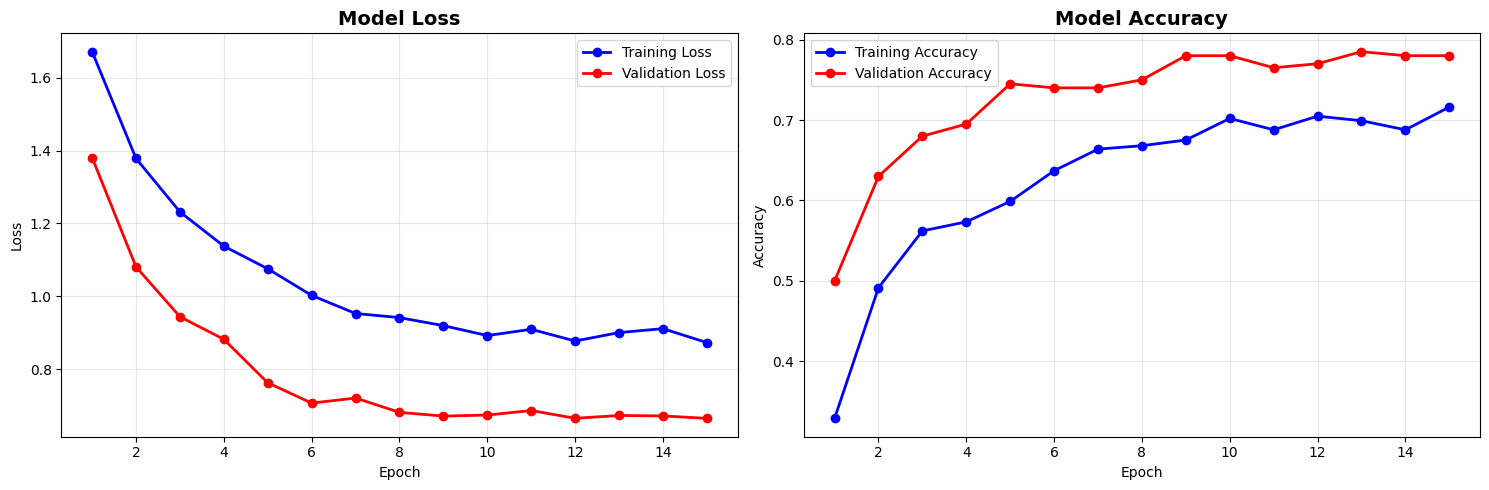

FINAL TRAINING METRICS
Best Validation Accuracy: 0.7850
Final Training Accuracy: 0.7161
Final Training Loss: 0.8730
Final Validation Loss: 0.6647
Training Time: 2m 48s

 MODEL TRAINING COMPLETE!
 Model trained and saved successfully
  Ready for detailed evaluation (Notebook 3)
 Expected performance: 80-90% accuracy on Irish landmarks


In [27]:
# CELL 13: Training Visualization
def plot_training_history(history):
    """Plot training curves"""
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, history['train_losses'], 'b-o', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-o', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(epochs, history['train_accs'], 'b-o', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accs'], 'r-o', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("FINAL TRAINING METRICS")
    print("=" * 30)
    print(f"Best Validation Accuracy: {history['best_val_acc']:.4f}")
    print(f"Final Training Accuracy: {history['train_accs'][-1]:.4f}")
    print(f"Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"Training Time: {history['training_time']//60:.0f}m {history['training_time']%60:.0f}s")

# Plot training history
plot_training_history(training_history)

print("\n MODEL TRAINING COMPLETE!")
print("=" * 40)
print(" Model trained and saved successfully")
print("  Ready for detailed evaluation (Notebook 3)")
print(" Expected performance: 80-90% accuracy on Irish landmarks")